In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

from openfermion.hamiltonians import MolecularData
from openfermionpsi4 import run_psi4
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev
from scipy.sparse.linalg import eigs
from scipy.linalg import expm
from openfermion.utils import get_ground_state
from openfermion.transforms import get_sparse_operator

In [2]:
def delta_Agate(bond_length):
    #パウリ演算子の準備
    nqubits = 4
    pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
    pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
    pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
    pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
    pHad = (pX+pZ)/np.sqrt(2)
    pP0 = (pI+pZ)/2
    pP1 = (pI-pZ)/2
    
    #任意の状態に演算できるように準備
    X=[1]*(nqubits)
    Y=[1]*(nqubits)
    Z=[1]*(nqubits)
    H=[1]*(nqubits)
    P0=[1]*(nqubits)
    P1=[1]*(nqubits)
    for i in range(nqubits):
        for j in range(nqubits):
            if(i != j):
                X[i] = np.kron(pI,X[i])
                Y[i] = np.kron(pI,Y[i])
                Z[i] = np.kron(pI,Z[i])
                H[i] = np.kron(pI,H[i])
                P0[i] = np.kron(pI,P0[i])
                P1[i] = np.kron(pI,P1[i])
            else:
                X[i] = np.kron(pX,X[i])
                Y[i] = np.kron(pY,Y[i])
                Z[i] = np.kron(pZ,Z[i])
                H[i] = np.kron(pHad,H[i])
                P0[i] = np.kron(pP0,P0[i])
                P1[i] = np.kron(pP1,P1[i])
    Ide = np.eye(2**nqubits)
    
    #2量子ゲートの準備
    CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
    CX = [[0 for i in range(nqubits)] for j in range(nqubits)]
    for i in range(nqubits):
        for j in range(nqubits):
            CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
            CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))
        
    #変分量子ゲートの準備
    def iSWAP(target1,target2,angle):
        return expm(-0.5*angle*1.j*CX[target1][target2])
    def iCPHASE(target1,target2,angle):
        return expm(-0.5*angle*1.j*CZ[target1][target2])
    def RX(target,angle):
        return expm(-0.5*angle*1.j*X[target])
    def RY(target,angle):
        return expm(-0.5*angle*1.j*Y[target])
    def RZ(target,angle):
        return expm(-0.5*angle*1.j*Z[target])

    #初期状態の準備
    def StateZeros(nqubits):
        State = np.zeros(2**nqubits)
        State[0]=1
        return State

    #求めるハミルトニアンのデータ
    geometry = [["H", [0,0,0]],
                ["H", [0,0,bond_length]]]
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    description = "test" #str()

    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    
    #求めるハミルトニアンのJW変換
    molecule = run_psi4(molecule)

    jw_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))

    jw_matrix = get_sparse_operator(jw_hamiltonian)
    
    #量子回路
    n_param = 12
    def QubitPQC(phi):
        p=0.0000000001 #single qubit gateのdepolarizing error
        q=0.0000000001 #2 qubits gateのdepolarizing error
        def dot3(a1,a2,a3):
            return np.dot(np.dot(a1,a2),a3)
        def depolarize1(State,qubit):
            return (1-p)*State+p/3*(np.dot(X[qubit],State)+np.dot(Y[qubit],State)+np.dot(Z[qubit],State))
        def depolarize2(State,qubit1,qubit2):
            return (1-q)*State+q/15*(dot3(X[qubit1],X[qubit2],State)+dot3(X[qubit1],Y[qubit2],State)
                                     +dot3(X[qubit1],Z[qubit2],State)+dot3(Y[qubit1],X[qubit2],State)
                                     +dot3(Y[qubit1],Y[qubit2],State)+dot3(Y[qubit1],Z[qubit2],State)
                                     +dot3(Z[qubit1],X[qubit2],State)+dot3(Z[qubit1],Y[qubit2],State)
                                     +dot3(Z[qubit1],Z[qubit2],State))
        
        state = StateZeros(4)
    
        state = np.dot(X[1],state)
        state = depolarize1(state,1)
        state = np.dot(X[2],state)
        state = depolarize1(state,2)
        
        state = np.dot(CX[1][0],state)
        state = depolarize2(state,0,1)
        state = np.dot(RX(1,- phi[0]),state)
        state = depolarize1(state,1)
        state = np.dot(RZ(1,- phi[1]),state)
        state = depolarize1(state,1)
        state = np.dot(CX[0][1],state)
        state = depolarize2(state,0,1)
        state = np.dot(RZ(1,phi[1]),state)
        state = depolarize1(state,1)
        state = np.dot(RX(1,phi[0]),state)
        state = depolarize1(state,1)
        state = np.dot(CX[1][0],state)
        state = depolarize2(state,0,1)
        
        state = np.dot(CX[3][2],state)
        state = depolarize2(state,2,3)
        state = np.dot(RX(3,- phi[2]),state)
        state = depolarize1(state,3)
        state = np.dot(RZ(3,- phi[3]),state)
        state = depolarize1(state,3)
        state = np.dot(CX[2][3],state)
        state = depolarize2(state,2,3)
        state = np.dot(RZ(3,phi[3]),state)
        state = depolarize1(state,3)
        state = np.dot(RX(3,phi[2]),state)
        state = depolarize1(state,3)
        state = np.dot(CX[3][2],state)
        state = depolarize2(state,2,3)
        
        state = np.dot(CX[2][1],state)
        state = depolarize2(state,1,2)
        state = np.dot(RX(2,- phi[4]),state)
        state = depolarize1(state,2)
        state = np.dot(RZ(2,- phi[5]),state)
        state = depolarize1(state,2)
        state = np.dot(CX[1][2],state)
        state = depolarize2(state,1,2)
        state = np.dot(RZ(2,phi[5]),state)
        state = depolarize1(state,2)
        state = np.dot(RX(2,phi[4]),state)
        state = depolarize1(state,2)
        state = np.dot(CX[2][1],state)
        state = depolarize2(state,1,2)
       
        state = np.dot(CX[1][0],state)
        state = depolarize2(state,0,1)
        state = np.dot(RX(1,- phi[6]),state)
        state = depolarize1(state,1)
        state = np.dot(RZ(1,- phi[7]),state)
        state = depolarize1(state,1)
        state = np.dot(CX[0][1],state)
        state = depolarize2(state,0,1)
        state = np.dot(RZ(1,phi[7]),state)
        state = depolarize1(state,1)
        state = np.dot(RX(1,phi[6]),state)
        state = depolarize1(state,1)
        state = np.dot(CX[1][0],state)
        state = depolarize2(state,0,1)
        
        state = np.dot(CX[3][2],state)
        state = depolarize2(state,2,3)
        state = np.dot(RX(3,- phi[8]),state)
        state = depolarize1(state,3)
        state = np.dot(RZ(3,- phi[9]),state)
        state = depolarize1(state,3)
        state = np.dot(CX[2][3],state)
        state = depolarize2(state,2,3)
        state = np.dot(RZ(3,phi[9]),state)
        state = depolarize1(state,3)
        state = np.dot(RX(3,phi[8]),state)
        state = depolarize1(state,3)
        state = np.dot(CX[3][2],state)
        state = depolarize2(state,2,3)
        
        state = np.dot(CX[2][1],state)
        state = depolarize2(state,1,2)
        state = np.dot(RX(2,- phi[10]),state)
        state = depolarize1(state,2)
        state = np.dot(RZ(2,- phi[11]),state)
        state = depolarize1(state,2)
        state = np.dot(CX[1][2],state)
        state = depolarize2(state,1,2)
        state = np.dot(RZ(2,phi[11]),state)
        state = depolarize1(state,2)
        state = np.dot(RX(2,phi[10]),state)
        state = depolarize1(state,2)
        state = np.dot(CX[2][1],state)
        state = depolarize2(state,1,2)
        
        return state

    #エネルギーの期待値を求める関数
    def ExpectVal(Operator,State):
        BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
        tmp = BraState.dot(Operator.dot(State)) #行列を列ベクトルと行ベクトルではさむ
        return np.real(tmp) #要素の実部を取り出す

    #VQEの実行
    def cost(phi):
        return ExpectVal(jw_matrix, QubitPQC(phi))

    init = np.random.rand(n_param)
    res = scipy.optimize.minimize(cost, init,
                              method='Powell')
    
    #FCI計算
    molecule = run_psi4(molecule,run_scf=1,run_fci=1)
    eigenenergies, eigenvecs = eigs(jw_matrix)
    FCI = float(molecule.fci_energy)
    
    return cost(res.x)-FCI

In [3]:
def delta_hard(bond_length):
    #パウリ演算子の準備
    nqubits = 4
    pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
    pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
    pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
    pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
    pHad = (pX+pZ)/np.sqrt(2)
    pP0 = (pI+pZ)/2
    pP1 = (pI-pZ)/2
    
    #任意の状態に演算できるように準備
    X=[1]*(nqubits)
    Y=[1]*(nqubits)
    Z=[1]*(nqubits)
    H=[1]*(nqubits)
    P0=[1]*(nqubits)
    P1=[1]*(nqubits)
    for i in range(nqubits):
        for j in range(nqubits):
            if(i != j):
                X[i] = np.kron(pI,X[i])
                Y[i] = np.kron(pI,Y[i])
                Z[i] = np.kron(pI,Z[i])
                H[i] = np.kron(pI,H[i])
                P0[i] = np.kron(pI,P0[i])
                P1[i] = np.kron(pI,P1[i])
            else:
                X[i] = np.kron(pX,X[i])
                Y[i] = np.kron(pY,Y[i])
                Z[i] = np.kron(pZ,Z[i])
                H[i] = np.kron(pHad,H[i])
                P0[i] = np.kron(pP0,P0[i])
                P1[i] = np.kron(pP1,P1[i])
    Ide = np.eye(2**nqubits)
    
    #2量子ゲートの準備
    CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
    CX = [[0 for i in range(nqubits)] for j in range(nqubits)]
    for i in range(nqubits):
        for j in range(nqubits):
            CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
            CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))
        
    #変分量子ゲートの準備
    def iSWAP(target1,target2,angle):
        return expm(-0.5*angle*1.j*CX[target1][target2])
    def iCPHASE(target1,target2,angle):
        return expm(-0.5*angle*1.j*CZ[target1][target2])
    def RX(target,angle):
        return expm(-0.5*angle*1.j*X[target])
    def RY(target,angle):
        return expm(-0.5*angle*1.j*Y[target])
    def RZ(target,angle):
        return expm(-0.5*angle*1.j*Z[target])

    #初期状態の準備
    def StateZeros(nqubits):
        State = np.zeros(2**nqubits)
        State[0]=1
        return State

    #求めるハミルトニアンのデータ
    geometry = [["H", [0,0,0]],
                ["H", [0,0,bond_length]]]
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    description = "test" #str()

    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    
    #求めるハミルトニアンのJW変換
    molecule = run_psi4(molecule)

    jw_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))

    jw_matrix = get_sparse_operator(jw_hamiltonian)
    
    #量子回路
    n_param = 32
    def QubitPQC(phi):
        p=0.0000000001 #single qubit gateのdepolarizing error
        q=0.0000000001 #2 qubits gateのdepolarizing error
        def dot3(a1,a2,a3):
            return np.dot(np.dot(a1,a2),a3)
        def depolarize1(State,qubit):
            return (1-p)*State+p/3*(np.dot(X[qubit],State)+np.dot(Y[qubit],State)+np.dot(Z[qubit],State))
        def depolarize2(State,qubit1,qubit2):
            return (1-q)*State+q/15*(dot3(X[qubit1],X[qubit2],State)+dot3(X[qubit1],Y[qubit2],State)
                                +dot3(X[qubit1],Z[qubit2],State)+dot3(Y[qubit1],X[qubit2],State)
                                +dot3(Y[qubit1],Y[qubit2],State)+dot3(Y[qubit1],Z[qubit2],State)
                                +dot3(Z[qubit1],X[qubit2],State)+dot3(Z[qubit1],Y[qubit2],State)
                                +dot3(Z[qubit1],Z[qubit2],State))
        
        state = StateZeros(4)

        state = np.dot(RX(0,phi[0]),state)
        state = depolarize1(state,0)
        state = np.dot(RZ(0,phi[1]),state)
        state = depolarize1(state,0)
        state = np.dot(RX(1,phi[2]),state)
        state = depolarize1(state,1)
        state = np.dot(RZ(1,phi[3]),state)
        state = depolarize1(state,1)
        state = np.dot(RX(2,phi[4]),state)
        state = depolarize1(state,2)
        state = np.dot(RZ(2,phi[5]),state)
        state = depolarize1(state,2)
        state = np.dot(RX(3,phi[6]),state)
        state = depolarize1(state,3)
        state = np.dot(RZ(3,phi[7]),state)
        state = depolarize1(state,3)
    
        state = np.dot(CX[0][1],state)
        state = depolarize2(state,0,1)
        state = np.dot(CX[2][3],state)
        state = depolarize2(state,1,2)
        state = np.dot(CX[1][2],state)
        state = depolarize2(state,2,3)
    
        state = np.dot(RX(0,phi[8]),state)
        state = depolarize1(state,0)
        state = np.dot(RZ(0,phi[9]),state)
        state = depolarize1(state,0)
        state = np.dot(RX(1,phi[10]),state)
        state = depolarize1(state,1)
        state = np.dot(RZ(1,phi[11]),state)
        state = depolarize1(state,1)
        state = np.dot(RX(2,phi[12]),state)
        state = depolarize1(state,2)
        state = np.dot(RZ(2,phi[13]),state)
        state = depolarize1(state,2)
        state = np.dot(RX(3,phi[14]),state)
        state = depolarize1(state,3)
        state = np.dot(RZ(3,phi[15]),state)
        state = depolarize1(state,3)
       
        state = np.dot(CX[0][1],state)
        state = depolarize2(state,0,1)
        state = np.dot(CX[2][3],state)
        state = depolarize2(state,1,2)
        state = np.dot(CX[1][2],state)
        state = depolarize2(state,2,3)
        
        state = np.dot(RX(0,phi[16]),state)
        state = depolarize1(state,0)
        state = np.dot(RZ(0,phi[17]),state)
        state = depolarize1(state,0)
        state = np.dot(RX(1,phi[18]),state)
        state = depolarize1(state,1)
        state = np.dot(RZ(1,phi[19]),state)
        state = depolarize1(state,1)
        state = np.dot(RX(2,phi[20]),state)
        state = depolarize1(state,2)
        state = np.dot(RZ(2,phi[21]),state)
        state = depolarize1(state,2)
        state = np.dot(RX(3,phi[22]),state)
        state = depolarize1(state,3)
        state = np.dot(RZ(3,phi[23]),state)
        state = depolarize1(state,3)
        
        state = np.dot(CX[0][1],state)
        state = depolarize2(state,0,1)
        state = np.dot(CX[2][3],state)
        state = depolarize2(state,1,2)
        state = np.dot(CX[1][2],state)
        state = depolarize2(state,2,3)
        
        state = np.dot(RX(0,phi[24]),state)
        state = depolarize1(state,0)
        state = np.dot(RZ(0,phi[25]),state)
        state = depolarize1(state,0)
        state = np.dot(RX(1,phi[26]),state)
        state = depolarize1(state,1)
        state = np.dot(RZ(1,phi[27]),state)
        state = depolarize1(state,1)
        state = np.dot(RX(2,phi[28]),state)
        state = depolarize1(state,2)
        state = np.dot(RZ(2,phi[29]),state)
        state = depolarize1(state,2)
        state = np.dot(RX(3,phi[30]),state)
        state = depolarize1(state,3)
        state = np.dot(RZ(3,phi[31]),state)
        state = depolarize1(state,3)
    
        return state

    #エネルギーの期待値を求める関数
    def ExpectVal(Operator,State):
        BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
        tmp = BraState.dot(Operator.dot(State)) #行列を列ベクトルと行ベクトルではさむ
        return np.real(tmp) #要素の実部を取り出す

    #VQEの実行
    def cost(phi):
        return ExpectVal(jw_matrix, QubitPQC(phi))

    init = np.random.rand(n_param)
    res = scipy.optimize.minimize(cost, init,
                              method='Powell')
    
    molecule = run_psi4(molecule,run_scf=1,run_fci=1)
    eigenenergies, eigenvecs = eigs(jw_matrix)
    FCI = float(molecule.fci_energy)
    
    return cost(res.x)-FCI

In [4]:
def g_phi(bond_length):
    #パウリ演算子の準備
    nqubits = 4
    pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
    pPLUS = np.array([[0+0.0j,1+0.0j],[0+0.0j,0+0.0j]])
    pMINUS = np.array([[0+0.0j,0+0.0j],[1+0.0j,0+0.0j]])
    
    def TENSOR(a1,a2,a3,a4):
        return np.kron(np.kron(np.kron(a1,a2),a3),a4)
        
    #Hamiltonian
    def H12(theta,g):
        return g*(np.exp(theta*1.j)*TENSOR(pPLUS,pMINUS,pI,pI)+np.exp(-theta*1.j)*TENSOR(pMINUS,pPLUS,pI,pI))
    def H13(theta,g):
        return g*(np.exp(theta*1.j)*TENSOR(pPLUS,pI,pMINUS,pI)+np.exp(-theta*1.j)*TENSOR(pMINUS,pI,pPLUS,pI))
    def H14(theta,g):
        return g*(np.exp(theta*1.j)*TENSOR(pPLUS,pI,pI,pMINUS)+np.exp(-theta*1.j)*TENSOR(pMINUS,pI,pI,pPLUS))
    def H23(theta,g):
        return g*(np.exp(theta*1.j)*TENSOR(pI,pPLUS,pMINUS,pI)+np.exp(-theta*1.j)*TENSOR(pI,pMINUS,pPLUS,pI))
    def H24(theta,g):
        return g*(np.exp(theta*1.j)*TENSOR(pI,pPLUS,pI,pMINUS)+np.exp(-theta*1.j)*TENSOR(pI,pMINUS,pI,pPLUS))
    def H34(theta,g):
        return g*(np.exp(theta*1.j)*TENSOR(pI,pI,pPLUS,pMINUS)+np.exp(-theta*1.j)*TENSOR(pI,pI,pMINUS,pPLUS))
    
    def U(g12,g13,g14,g23,g24,g34,theta1,theta2,theta3,theta4,theta5,theta6):
        return expm(-0.5*1.j*(H12(theta1,g12)+H13(theta2,g13)+H14(theta3,g14)+H23(theta4,g23)+H24(theta5,g24)+H34(theta6,g34)))
    
    #初期状態の準備
    def StateZeros(nqubits):
        State = np.zeros(2**nqubits)
        State[0]=1
        return State

    #求めるハミルトニアンのデータ
    geometry = [["H", [0,0,0]],
                ["H", [0,0,bond_length]]]
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    description = "test" #str()

    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    
    #求めるハミルトニアンのJW変換
    molecule = run_psi4(molecule)

    jw_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))

    jw_matrix = get_sparse_operator(jw_hamiltonian)
    
    #量子回路
    n_param = 12
    def QubitPQC(phi):
        p=0.0000000001 #single qubit gateのdepolarizing error
        q=0.0000000001 #2 qubits gateのdepolarizing error
        def dot3(a1,a2,a3):
            return np.dot(np.dot(a1,a2),a3)
        def depolarize1(State,qubit):
            return (1-p)*State+p/3*(np.dot(X[qubit],State)+np.dot(Y[qubit],State)+np.dot(Z[qubit],State))
        def depolarize2(State,qubit1,qubit2):
            return (1-q)*State+q/15*(dot3(X[qubit1],X[qubit2],State)+dot3(X[qubit1],Y[qubit2],State)
                                     +dot3(X[qubit1],Z[qubit2],State)+dot3(Y[qubit1],X[qubit2],State)
                                     +dot3(Y[qubit1],Y[qubit2],State)+dot3(Y[qubit1],Z[qubit2],State)
                                     +dot3(Z[qubit1],X[qubit2],State)+dot3(Z[qubit1],Y[qubit2],State)
                                     +dot3(Z[qubit1],Z[qubit2],State))
        
        state = StateZeros(4)
        
        state = np.dot(X[1],state)
        state = depolarize1(state,1)
        state = np.dot(X[2],state)
        state = depolarize1(state,2)
   
        state = np.dot(U(phi[0],phi[1],phi[2],phi[3],phi[4],phi[5],phi[6],phi[7],phi[8],phi[9],phi[10],phi[11]),state)
    
        state = depolarize2(state,0,1)
        state = depolarize2(state,0,2)
        state = depolarize2(state,0,3)
        state = depolarize2(state,1,2)
        state = depolarize2(state,1,3)
        state = depolarize2(state,2,3)
        
        return state
    
    #エネルギーの期待値を求める関数
    def ExpectVal(Operator,State):
        BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
        tmp = BraState.dot(Operator.dot(State)) #行列を列ベクトルと行ベクトルではさむ
        return np.real(tmp) #要素の実部を取り出す

    #VQEの実行
    def cost(phi):
        return ExpectVal(jw_matrix, QubitPQC(phi))

    init = np.random.rand(n_param)
    res = scipy.optimize.minimize(cost, init,
                              method='Powell')
    
    molecule = run_psi4(molecule,run_scf=1,run_fci=1)
    eigenenergies, eigenvecs = eigs(jw_matrix)
    FCI = float(molecule.fci_energy)
    
    return cost(res.x)-FCI

In [5]:
def delta_fullhard(bond_length):
    #パウリ演算子の準備
    nqubits = 4
    pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
    pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
    pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
    pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
    pHad = (pX+pZ)/np.sqrt(2)
    pP0 = (pI+pZ)/2
    pP1 = (pI-pZ)/2
    
    #任意の状態に演算できるように準備
    X=[1]*(nqubits)
    Y=[1]*(nqubits)
    Z=[1]*(nqubits)
    H=[1]*(nqubits)
    P0=[1]*(nqubits)
    P1=[1]*(nqubits)
    for i in range(nqubits):
        for j in range(nqubits):
            if(i != j):
                X[i] = np.kron(pI,X[i])
                Y[i] = np.kron(pI,Y[i])
                Z[i] = np.kron(pI,Z[i])
                H[i] = np.kron(pI,H[i])
                P0[i] = np.kron(pI,P0[i])
                P1[i] = np.kron(pI,P1[i])
            else:
                X[i] = np.kron(pX,X[i])
                Y[i] = np.kron(pY,Y[i])
                Z[i] = np.kron(pZ,Z[i])
                H[i] = np.kron(pHad,H[i])
                P0[i] = np.kron(pP0,P0[i])
                P1[i] = np.kron(pP1,P1[i])
    Ide = np.eye(2**nqubits)
    
    #2量子ゲートの準備
    CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
    CX = [[0 for i in range(nqubits)] for j in range(nqubits)]
    for i in range(nqubits):
        for j in range(nqubits):
            CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
            CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))
        
    #変分量子ゲートの準備
    def iSWAP(target1,target2,angle):
        return expm(-0.5*angle*1.j*CX[target1][target2])
    def iCPHASE(target1,target2,angle):
        return expm(-0.5*angle*1.j*CZ[target1][target2])
    def RX(target,angle):
        return expm(-0.5*angle*1.j*X[target])
    def RY(target,angle):
        return expm(-0.5*angle*1.j*Y[target])
    def RZ(target,angle):
        return expm(-0.5*angle*1.j*Z[target])

    #初期状態の準備
    def StateZeros(nqubits):
        State = np.zeros(2**nqubits)
        State[0]=1
        return State

    #求めるハミルトニアンのデータ
    geometry = [["H", [0,0,0]],
                ["H", [0,0,bond_length]]]
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    description = "test" #str()

    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    
    #求めるハミルトニアンのJW変換
    molecule = run_psi4(molecule)

    jw_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))

    jw_matrix = get_sparse_operator(jw_hamiltonian)
    
    #量子回路
    n_param = 32
    def QubitPQC(phi):
        p=0.0000000001 #single qubit gateのdepolarizing error
        q=0.0000000001 #2 qubits gateのdepolarizing error
        def dot3(a1,a2,a3):
            return np.dot(np.dot(a1,a2),a3)
        def depolarize1(State,qubit):
            return (1-p)*State+p/3*(np.dot(X[qubit],State)+np.dot(Y[qubit],State)+np.dot(Z[qubit],State))
        def depolarize2(State,qubit1,qubit2):
            return (1-q)*State+q/15*(dot3(X[qubit1],X[qubit2],State)+dot3(X[qubit1],Y[qubit2],State)
                                +dot3(X[qubit1],Z[qubit2],State)+dot3(Y[qubit1],X[qubit2],State)
                                +dot3(Y[qubit1],Y[qubit2],State)+dot3(Y[qubit1],Z[qubit2],State)
                                +dot3(Z[qubit1],X[qubit2],State)+dot3(Z[qubit1],Y[qubit2],State)
                                +dot3(Z[qubit1],Z[qubit2],State))
        state = StateZeros(4)

        state = np.dot(RX(0,phi[0]),state)
        state = depolarize1(state,0)
        state = np.dot(RZ(0,phi[1]),state)
        state = depolarize1(state,0)
        state = np.dot(RX(1,phi[2]),state)
        state = depolarize1(state,1)
        state = np.dot(RZ(1,phi[3]),state)
        state = depolarize1(state,1)
        state = np.dot(RX(2,phi[4]),state)
        state = depolarize1(state,2)
        state = np.dot(RZ(2,phi[5]),state)
        state = depolarize1(state,2)
        state = np.dot(RX(3,phi[6]),state)
        state = depolarize1(state,3)
        state = np.dot(RZ(3,phi[7]),state)
        state = depolarize1(state,3)
    
        state = np.dot(CX[0][1],state)
        state = depolarize2(state,0,1)
        state = np.dot(CX[0][2],state)
        state = depolarize2(state,0,2)
        state = np.dot(CX[0][3],state)
        state = depolarize2(state,0,3)
        state = np.dot(CX[1][2],state)
        state = depolarize2(state,1,2)
        state = np.dot(CX[1][3],state)
        state = depolarize2(state,1,3)
        state = np.dot(CX[2][3],state)
        state = depolarize2(state,2,3)
    
        state = np.dot(RX(0,phi[8]),state)
        state = depolarize1(state,0)
        state = np.dot(RZ(0,phi[9]),state)
        state = depolarize1(state,0)
        state = np.dot(RX(1,phi[10]),state)
        state = depolarize1(state,1)
        state = np.dot(RZ(1,phi[11]),state)
        state = depolarize1(state,1)
        state = np.dot(RX(2,phi[12]),state)
        state = depolarize1(state,2)
        state = np.dot(RZ(2,phi[13]),state)
        state = depolarize1(state,2)
        state = np.dot(RX(3,phi[14]),state)
        state = depolarize1(state,3)
        state = np.dot(RZ(3,phi[15]),state)
        state = depolarize1(state,3)
       
        state = np.dot(CX[0][1],state)
        state = depolarize2(state,0,1)
        state = np.dot(CX[0][2],state)
        state = depolarize2(state,0,2)
        state = np.dot(CX[0][3],state)
        state = depolarize2(state,0,3)
        state = np.dot(CX[1][2],state)
        state = depolarize2(state,1,2)
        state = np.dot(CX[1][3],state)
        state = depolarize2(state,1,3)
        state = np.dot(CX[2][3],state)
        state = depolarize2(state,2,3)
        
        state = np.dot(RX(0,phi[16]),state)
        state = depolarize1(state,0)
        state = np.dot(RZ(0,phi[17]),state)
        state = depolarize1(state,0)
        state = np.dot(RX(1,phi[18]),state)
        state = depolarize1(state,1)
        state = np.dot(RZ(1,phi[19]),state)
        state = depolarize1(state,1)
        state = np.dot(RX(2,phi[20]),state)
        state = depolarize1(state,2)
        state = np.dot(RZ(2,phi[21]),state)
        state = depolarize1(state,2)
        state = np.dot(RX(3,phi[22]),state)
        state = depolarize1(state,3)
        state = np.dot(RZ(3,phi[23]),state)
        state = depolarize1(state,3)
        
        state = np.dot(CX[0][1],state)
        state = depolarize2(state,0,1)
        state = np.dot(CX[0][2],state)
        state = depolarize2(state,0,2)
        state = np.dot(CX[0][3],state)
        state = depolarize2(state,0,3)
        state = np.dot(CX[1][2],state)
        state = depolarize2(state,1,2)
        state = np.dot(CX[1][3],state)
        state = depolarize2(state,1,3)
        state = np.dot(CX[2][3],state)
        state = depolarize2(state,2,3)
        
        state = np.dot(RX(0,phi[24]),state)
        state = depolarize1(state,0)
        state = np.dot(RZ(0,phi[25]),state)
        state = depolarize1(state,0)
        state = np.dot(RX(1,phi[26]),state)
        state = depolarize1(state,1)
        state = np.dot(RZ(1,phi[27]),state)
        state = depolarize1(state,1)
        state = np.dot(RX(2,phi[28]),state)
        state = depolarize1(state,2)
        state = np.dot(RZ(2,phi[29]),state)
        state = depolarize1(state,2)
        state = np.dot(RX(3,phi[30]),state)
        state = depolarize1(state,3)
        state = np.dot(RZ(3,phi[31]),state)
        state = depolarize1(state,3)
    
        return state

    #エネルギーの期待値を求める関数
    def ExpectVal(Operator,State):
        BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
        tmp = BraState.dot(Operator.dot(State)) #行列を列ベクトルと行ベクトルではさむ
        return np.real(tmp) #要素の実部を取り出す

    #VQEの実行
    def cost(phi):
        return ExpectVal(jw_matrix, QubitPQC(phi))

    init = np.random.rand(n_param)
    res = scipy.optimize.minimize(cost, init,
                              method='Powell')
    
    molecule = run_psi4(molecule,run_scf=1,run_fci=1)
    eigenenergies, eigenvecs = eigs(jw_matrix)
    FCI = float(molecule.fci_energy)
    
    return cost(res.x)-FCI

In [6]:
def delta_fSimRz(bond_length):
    #パウリ演算子の準備
    nqubits = 4
    pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
    pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
    pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
    pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
    pHad = (pX+pZ)/np.sqrt(2)
    pP0 = (pI+pZ)/2
    pP1 = (pI-pZ)/2
    
    #任意の状態に演算できるように準備
    X=[1]*(nqubits)
    Y=[1]*(nqubits)
    Z=[1]*(nqubits)
    H=[1]*(nqubits)
    P0=[1]*(nqubits)
    P1=[1]*(nqubits)
    for i in range(nqubits):
        for j in range(nqubits):
            if(i != j):
                X[i] = np.kron(pI,X[i])
                Y[i] = np.kron(pI,Y[i])
                Z[i] = np.kron(pI,Z[i])
                H[i] = np.kron(pI,H[i])
                P0[i] = np.kron(pI,P0[i])
                P1[i] = np.kron(pI,P1[i])
            else:
                X[i] = np.kron(pX,X[i])
                Y[i] = np.kron(pY,Y[i])
                Z[i] = np.kron(pZ,Z[i])
                H[i] = np.kron(pHad,H[i])
                P0[i] = np.kron(pP0,P0[i])
                P1[i] = np.kron(pP1,P1[i])
    Ide = np.eye(2**nqubits)
    
    #2量子ゲートの準備
    CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
    CX = [[0 for i in range(nqubits)] for j in range(nqubits)]
    for i in range(nqubits):
        for j in range(nqubits):
            CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
            CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))
    
    
    def TENSOR3(a1,a2,a3):
        return np.kron(np.kron(a1,a2),a3)
    #SWAP
    H = np.kron(pX,pX)+np.kron(pY,pY)
    H01 = TENSOR3(H,pI,pI)
    H12 = TENSOR3(pI,H,pI)
    H23 = TENSOR3(pI,pI,H)    
            
    #変分量子ゲートの準備
    def iSWAPlike12(angle):
        return expm(-0.5*angle*1.j*H01)
    def iSWAPlike23(angle):
        return expm(-0.5*angle*1.j*H12)
    def iSWAPlike34(angle):
        return expm(-0.5*angle*1.j*H23)
    def RX(target,angle):
        return expm(-0.5*angle*1.j*X[target])
    def RY(target,angle):
        return expm(-0.5*angle*1.j*Y[target])
    def RZ(target,angle):
        return expm(-0.5*angle*1.j*Z[target])

    #初期状態の準備
    def StateZeros(nqubits):
        State = np.zeros(2**nqubits)
        State[0]=1
        return State

    #求めるハミルトニアンのデータ
    geometry = [["H", [0,0,0]],
                ["H", [0,0,bond_length]]]
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    description = "test" #str()

    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    
    #求めるハミルトニアンのJW変換
    molecule = run_psi4(molecule)

    jw_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))

    jw_matrix = get_sparse_operator(jw_hamiltonian)
    
    #量子回路
    n_param = 12
    def QubitPQC(phi):
        p=0.0000000001 #single qubit gateのdepolarizing error
        q=0.0000000001 #2 qubits gateのdepolarizing error
        def dot3(a1,a2,a3):
            return np.dot(np.dot(a1,a2),a3)
        def depolarize1(State,qubit):
            return (1-p)*State+p/3*(np.dot(X[qubit],State)+np.dot(Y[qubit],State)+np.dot(Z[qubit],State))
        def depolarize2(State,qubit1,qubit2):
            return (1-q)*State+q/15*(dot3(X[qubit1],X[qubit2],State)+dot3(X[qubit1],Y[qubit2],State)
                                     +dot3(X[qubit1],Z[qubit2],State)+dot3(Y[qubit1],X[qubit2],State)
                                     +dot3(Y[qubit1],Y[qubit2],State)+dot3(Y[qubit1],Z[qubit2],State)
                                     +dot3(Z[qubit1],X[qubit2],State)+dot3(Z[qubit1],Y[qubit2],State)
                                     +dot3(Z[qubit1],Z[qubit2],State))
        
        state = StateZeros(4)
    
        state = np.dot(X[1],state)
        state = depolarize1(state,1)
        state = np.dot(X[2],state)
        state = depolarize1(state,2)
   
        state = np.dot(Z[0],state)
        state = depolarize1(state,0)
        state = np.dot(RZ(1,-phi[0]),state)
        state = depolarize1(state,1)
        state = np.dot(iSWAPlike01(phi[1]),state)
        state = depolarize2(state,0,1)
        state = np.dot(CZ[0][1],state)
        state = depolarize2(state,0,1)
        state = np.dot(RZ(1,phi[0]),state)
        state = depolarize1(state,1)
    
        state = np.dot(Z[2],state)
        state = depolarize1(state,2)
        state = np.dot(RZ(3,phi[2]),state)
        state = depolarize1(state,3)
        state = np.dot(iSWAPlike23(phi[3]),state)
        state = depolarize2(state,2,3)
        state = np.dot(CZ[2][3],state)
        state = depolarize2(state,2,3)
        state = np.dot(RZ(3,-phi[2]),state)
        state = depolarize1(state,3)
    
        state = np.dot(Z[1],state)
        state = depolarize1(state,1)
        state = np.dot(RZ(2,phi[4]),state)
        state = depolarize1(state,2)
        state = np.dot(iSWAPlike12(phi[5]),state)
        state = depolarize2(state,1,2)
        state = np.dot(CZ[1][2],state)
        state = depolarize2(state,1,2)
        state = np.dot(RZ(2,-phi[4]),state)
        state = depolarize1(state,2)
    
        state = np.dot(Z[0],state)
        state = depolarize1(state,0)
        state = np.dot(RZ(1,phi[6]),state)
        state = depolarize1(state,1)
        state = np.dot(iSWAPlike01(phi[7]),state)
        state = depolarize2(state,0,1)
        state = np.dot(CZ[0][1],state)
        state = depolarize2(state,0,1)
        state = np.dot(RZ(1,-phi[6]),state)
        state = depolarize1(state,1)
    
        state = np.dot(Z[2],state)
        state = depolarize1(state,2)
        state = np.dot(RZ(3,phi[8]),state)
        state = depolarize1(state,3)
        state = np.dot(iSWAPlike23(phi[9]),state)
        state = depolarize2(state,2,3)
        state = np.dot(CZ[2][3],state)
        state = depolarize2(state,2,3)
        state = np.dot(RZ(3,-phi[8]),state)
        state = depolarize1(state,3)
    
        state = np.dot(Z[1],state)
        state = depolarize1(state,1)
        state = np.dot(RZ(2,phi[10]),state)
        state = depolarize1(state,2)
        state = np.dot(iSWAPlike12(phi[11]),state)
        state = depolarize2(state,1,2)
        state = np.dot(CZ[1][2],state)
        state = depolarize2(state,1,2)
        state = np.dot(RZ(2,-phi[10]),state)
        state = depolarize1(state,2)
    
        return state

    #エネルギーの期待値を求める関数
    def ExpectVal(Operator,State):
        BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
        tmp = BraState.dot(Operator.dot(State)) #行列を列ベクトルと行ベクトルではさむ
        return np.real(tmp) #要素の実部を取り出す

    #VQEの実行
    def cost(phi):
        return ExpectVal(jw_matrix, QubitPQC(phi))

    init = np.random.rand(n_param)
    res = scipy.optimize.minimize(cost, init,
                              method='Powell')
    
    molecule = run_psi4(molecule,run_scf=1,run_fci=1)
    eigenenergies, eigenvecs = eigs(jw_matrix)
    FCI = float(molecule.fci_energy)
    
    return cost(res.x)-FCI

In [ ]:
def delta_iswapRz(bond_length):
    #パウリ演算子の準備
    nqubits = 4
    pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
    pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
    pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
    pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
    pHad = (pX+pZ)/np.sqrt(2)
    pP0 = (pI+pZ)/2
    pP1 = (pI-pZ)/2
    
    #任意の状態に演算できるように準備
    X=[1]*(nqubits)
    Y=[1]*(nqubits)
    Z=[1]*(nqubits)
    H=[1]*(nqubits)
    P0=[1]*(nqubits)
    P1=[1]*(nqubits)
    for i in range(nqubits):
        for j in range(nqubits):
            if(i != j):
                X[i] = np.kron(pI,X[i])
                Y[i] = np.kron(pI,Y[i])
                Z[i] = np.kron(pI,Z[i])
                H[i] = np.kron(pI,H[i])
                P0[i] = np.kron(pI,P0[i])
                P1[i] = np.kron(pI,P1[i])
            else:
                X[i] = np.kron(pX,X[i])
                Y[i] = np.kron(pY,Y[i])
                Z[i] = np.kron(pZ,Z[i])
                H[i] = np.kron(pHad,H[i])
                P0[i] = np.kron(pP0,P0[i])
                P1[i] = np.kron(pP1,P1[i])
    Ide = np.eye(2**nqubits)
    
    #2量子ゲートの準備
    CZ = [[0 for i in range(nqubits)] for j in range(nqubits)]
    CX = [[0 for i in range(nqubits)] for j in range(nqubits)]
    for i in range(nqubits):
        for j in range(nqubits):
            CZ[i][j]= (P0[i]+np.dot(P1[i],Z[j]))
            CX[i][j]= (P0[i]+np.dot(P1[i],X[j]))
    
    #SWAP
    SWAP = np.array([[1+0.0j,0+0.0j,0+0.0j,0+0.0j],[0+0.0j,0+0.0j,1+0.0j,0+0.0j],[0+0.0j,1+0.0j,0+0.0j,0+0.0j],[0+0.0j,0+0.0j,0+0.0j,1+0.0j]])
    PSWAP01 = np.kron(SWAP,np.kron(pI,pI))
    PSWAP12 = np.kron(pI,np.kron(SWAP,pI))
    PSWAP23 = np.kron(pI,np.kron(pI,SWAP))
        
    #変分量子ゲートの準備
    def SWAP01(angle):
        return expm(-0.5*angle*1.j*PSWAP01)
    def SWAP12(angle):
        return expm(-0.5*angle*1.j*PSWAP12)
    def SWAP23(angle):
        return expm(-0.5*angle*1.j*PSWAP23)
    def CPHASE(target1,target2,angle):
        return expm(-0.5*angle*1.j*CZ[target1][target2])
    def RX(target,angle):
        return expm(-0.5*angle*1.j*X[target])
    def RY(target,angle):
        return expm(-0.5*angle*1.j*Y[target])
    def RZ(target,angle):
        return expm(-0.5*angle*1.j*Z[target])

    #初期状態の準備
    def StateZeros(nqubits):
        State = np.zeros(2**nqubits)
        State[0]=1
        return State

    #求めるハミルトニアンのデータ
    geometry = [["H", [0,0,0]],
                ["H", [0,0,bond_length]]]
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    description = "test" #str()

    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    
    #求めるハミルトニアンのJW変換
    molecule = run_psi4(molecule)

    jw_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))

    jw_matrix = get_sparse_operator(jw_hamiltonian)
    
    #量子回路
    n_param = 12
    def QubitPQC(phi):
        p=0.0000000001 #single qubit gateのdepolarizing error
        q=0.0000000001 #2 qubits gateのdepolarizing error
        def dot3(a1,a2,a3):
            return np.dot(np.dot(a1,a2),a3)
        def depolarize1(State,qubit):
            return (1-p)*State+p/3*(np.dot(X[qubit],State)+np.dot(Y[qubit],State)+np.dot(Z[qubit],State))
        def depolarize2(State,qubit1,qubit2):
            return (1-q)*State+q/15*(dot3(X[qubit1],X[qubit2],State)+dot3(X[qubit1],Y[qubit2],State)
                                     +dot3(X[qubit1],Z[qubit2],State)+dot3(Y[qubit1],X[qubit2],State)
                                     +dot3(Y[qubit1],Y[qubit2],State)+dot3(Y[qubit1],Z[qubit2],State)
                                     +dot3(Z[qubit1],X[qubit2],State)+dot3(Z[qubit1],Y[qubit2],State)
                                     +dot3(Z[qubit1],Z[qubit2],State))
        state = StateZeros(4)
    
        state = np.dot(X[1],state)
        state = depolarize1(state,1)
        state = np.dot(X[2],state)
        state = depolarize1(state,2)
   
        state = np.dot(RZ(1,phi[0]),state)
        state = depolarize1(state,1)
        state = np.dot(iSWAPlike12(phi[1]),state)
        state = depolarize2(state,0,1)
        state = np.dot(RZ(1,-phi[0]),state)
        state = depolarize1(state,1)
    
        state = np.dot(RZ(3,phi[2]),state)
        state = depolarize1(state,3)
        state = np.dot(iSWAPlike34(phi[3]),state)
        state = depolarize2(state,2,3)
        state = np.dot(RZ(3,-phi[2]),state)
        state = depolarize1(state,3)
    
        state = np.dot(RZ(2,phi[4]),state)
        state = depolarize1(state,2)
        state = np.dot(iSWAPlike23(phi[5]),state)
        state = depolarize2(state,1,2)
        state = np.dot(RZ(2,-phi[4]),state)
        state = depolarize1(state,2)
    
        state = np.dot(RZ(1,phi[6]),state)
        state = depolarize1(state,1)
        state = np.dot(iSWAPlike12(phi[7]),state)
        state = depolarize2(state,0,1)
        state = np.dot(RZ(1,-phi[6]),state)
        state = depolarize1(state,1)
    
        state = np.dot(RZ(3,phi[8]),state)
        state = depolarize1(state,3)
        state = np.dot(iSWAPlike34(phi[9]),state)
        state = depolarize2(state,2,3)
        state = np.dot(RZ(3,-phi[8]),state)
        state = depolarize1(state,3)
    
        state = np.dot(RZ(2,phi[10]),state)
        state = depolarize1(state,2)
        state = np.dot(iSWAPlike23(phi[11]),state)
        state = depolarize2(state,1,2)
        state = np.dot(RZ(2,-phi[10]),state)
        state = depolarize1(state,2)
    
        return state

    #エネルギーの期待値を求める関数
    def ExpectVal(Operator,State):
        BraState = np.conjugate(State.T) #列ベクトルを行ベクトルへ変換
        tmp = BraState.dot(Operator.dot(State)) #行列を列ベクトルと行ベクトルではさむ
        return np.real(tmp) #要素の実部を取り出す

    #VQEの実行
    def cost(phi):
        return ExpectVal(jw_matrix, QubitPQC(phi))

    init = np.random.rand(n_param)
    res = scipy.optimize.minimize(cost, init,
                              method='Powell')
    
    molecule = run_psi4(molecule,run_scf=1,run_fci=1)
    eigenenergies, eigenvecs = eigs(jw_matrix)
    FCI = float(molecule.fci_energy)
    
    return cost(res.x)-FCI

In [7]:
initial = 0.50
step = 0.025
number = 5*4+1
data1 = []
data2 = []
data3 = []
data4 = []
data5 = []
data6 = []
data7 = []
for i in range(number):
    bond_length = initial + i*step 
    data1.append(bond_length)
    hardw = delta_hard(bond_length)
    data2.append(hardw)
    fhardw = delta_fullhard(bond_length)
    data3.append(fhardw)
    Agate = delta_Agate(bond_length)
    data4.append(Agate)
    gphi = g_phi(bond_length)
    data5.append(gphi)
    fsim = delta_fSimRz(bond_length)
    data6.append(fsim)
    isawprz = delta_iswapRz(bond_length)
    data7.append(iswaprz)

<function matplotlib.pyplot.show(close=None, block=None)>

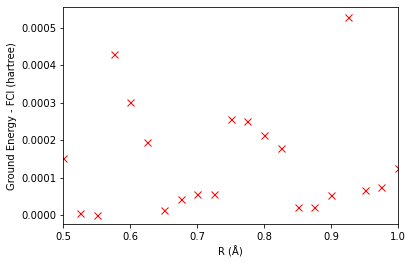

In [8]:
# 図にプロット
plt.plot(data1,data3,'rx', markersize=7)
plt.xlabel("$R$ (Å)")
plt.ylabel("Ground Energy - FCI (hartree)")
plt.xlim(0.50,1.00)
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

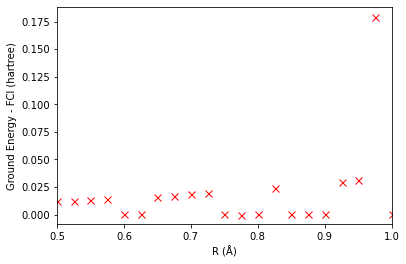

In [9]:
# 図にプロット
plt.plot(data1,data2,'rx', markersize=7)
plt.xlabel("$R$ (Å)")
plt.ylabel("Ground Energy - FCI (hartree)")
plt.xlim(0.50,1.00)
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

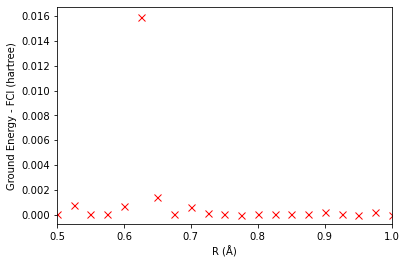

In [10]:
plt.plot(data1,data4,'rx', markersize=7)
plt.xlabel("$R$ (Å)")
plt.ylabel("Ground Energy - FCI (hartree)")
plt.xlim(0.50,1.00)
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

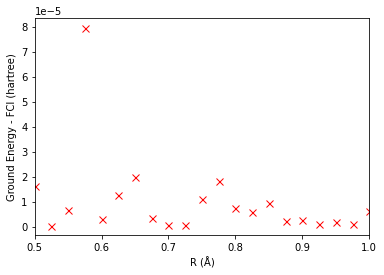

In [11]:
plt.plot(data1,data5,'rx', markersize=7)
plt.xlabel("$R$ (Å)")
plt.ylabel("Ground Energy - FCI (hartree)")
plt.xlim(0.50,1.00)
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

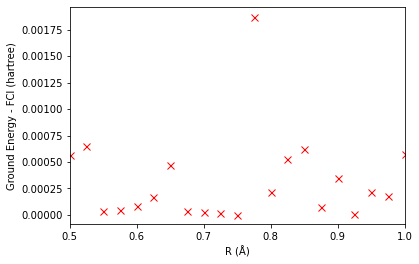

In [12]:
plt.plot(data1,data6,'rx', markersize=7)
plt.xlabel("$R$ (Å)")
plt.ylabel("Ground Energy - FCI (hartree)")
plt.xlim(0.50,1.00)
plt.show 

In [ ]:
plt.plot(data1,data6,'rx', markersize=7)
plt.xlabel("$R$ (Å)")
plt.ylabel("Ground Energy - FCI (hartree)")
plt.xlim(0.50,1.00)
plt.show 

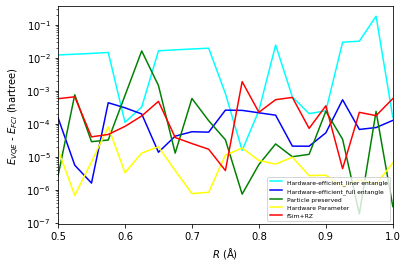

In [23]:
fig = plt.figure()
plt.plot(data1,data2,'aqua',linestyle='solid',label="Hardware-efficient_liner entangle")
plt.plot(data1,data3,'blue',linestyle='solid',label="Hardware-efficient_full entangle")
plt.plot(data1,data4,'green',linestyle='solid',label="Particle preserved")
plt.plot(data1,data5,'yellow',linestyle='solid',label="Hardware Parameter")
plt.plot(data1,data6,'red',linestyle='solid',label="fSim+RZ")
plt.plot(data1,data7,'purple',linestyle='solid',label="iSWAP+RZ")
plt.yscale('log')
plt.xlabel("$R$ (Å)")
plt.ylabel("${E_{VQE}}$ - ${E_{FCI}}$ (hartree)")
plt.xlim(0.50,1.00)
plt.legend(loc='lower right',prop={'size':6})

fig.savefig("deltaNEW1.png",dpi=300)